In [1]:
# importing required libraries 
import time
import numpy as np
import pandas as pd

# for pytorch imports
import torch

# for functional dependencies like activation function 
import torch.nn.functional as F

# nn is basic module in Torch which provide different neural network architecture
import torch.nn as nn

# for optimizer
import torch.optim as optim

# for padding .. since the LSTM takes input as sequence so it is said that 
#if we have fixed input string computation will be faster and it will improve performance 
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

from matplotlib import pyplot as plt

from torchinfo import summary

In [2]:
# ハイパーパラメータ
BATCH_SIZE = 16
N_EPOCH = 30

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

train data size:  60000
train iteration number:  3750


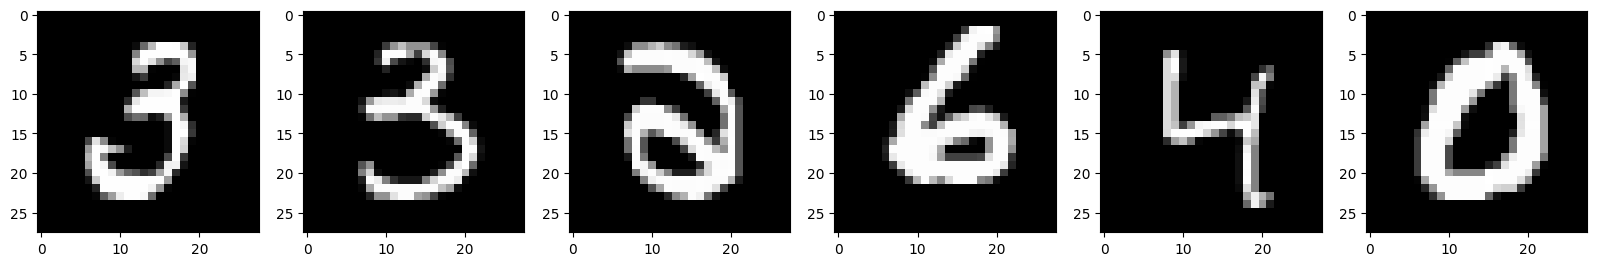

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST('../data', train = True, download = True, transform = transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

print("train data size: ",len(train_dataset))
print("train iteration number: ",len(train_dataloader)) 

images, labels = next(iter(train_dataloader))
image_numpy = images.detach().numpy().copy()
fig, axis = plt.subplots(1, 6, figsize=(20, 24))
for i, ax in enumerate(axis.flat):
    ax.imshow(image_numpy[i,0,:,:], cmap='gray')

In [5]:
# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()
#         self.conv1 = nn.Conv2d(1, 64, kernel_size=(3,3), stride=1, padding="same")
#         self.trans1 = nn.ConvTranspose2d(64, 64, kernel_size=(2,2), stride=2)
#         self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), stride=1, padding="same")
#         self.trans2 = nn.ConvTranspose2d(128, 128, kernel_size=(2,2), stride=2)
#         self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), stride=1, padding="same")
#         self.conv4 = nn.Conv2d(256, 1, kernel_size=(2,2), stride=1, padding="same")
#         self.relu = nn.LeakyReLU()
    
#     def forward(self, x):
#         x = self.relu(self.conv1(x))
#         x = self.trans1(x)
#         x = self.relu(self.conv2(x))
#         x = self.trans2(x)
#         x = self.relu(self.conv3(x))
#         x = torch.sigmoid(self.conv4(x))
#         return x

# model_G = Generator().to(device)
# model_G

In [6]:
# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
#         self.conv1 = nn.Conv2d(1, 64, kernel_size=(3,3), stride=1, padding="same")
#         self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), stride=1, padding="same")
#         self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), stride=1, padding="same")
#         self.pool = nn.AvgPool2d(kernel_size=(2,2), stride=2)
#         self.linear1 = nn.Linear(2048, 128)
#         self.linear2 = nn.Linear(128, 1)
#         self.drop1 = nn.Dropout(p=0.25)
#         self.drop2 = nn.Dropout(p=0.5)
#         self.flatten = nn.Flatten()
#         self.relu = nn.LeakyReLU()
    
#     def forward(self, x):
#         x = self.relu(self.conv1(x))
#         x = self.pool(x)
#         x = self.relu(self.conv2(x))
#         x = self.pool(x)
#         x = self.relu(self.conv3(x))
#         x = self.pool(x)
#         x = self.drop1(x)
#         x = self.flatten(x)
#         x = self.relu(self.linear1(x))
#         x = self.drop2(x)
#         x = torch.sigmoid(self.linear2(x))
#         return x

# model_D = Discriminator().to(device)
# model_D

In [7]:
class TwoConvBlock_2D(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding="same")
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.rl = nn.LeakyReLU()
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding="same")
    self.bn2 = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.rl(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.rl(x)
    return x

In [8]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = TwoConvBlock_2D(1,64)
    self.conv2 = TwoConvBlock_2D(64, 128)
    self.conv3 = TwoConvBlock_2D(128, 256)
    self.pool = nn.AvgPool2d(2, stride = 2)
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(256 * 3 * 3 , 128)
    self.l2 = nn.Linear(128, 1)
    self.relu = nn.LeakyReLU()
    self.dropout = nn.Dropout(0.25)

  def forward(self, x):
    x = self.conv1(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = self.pool(x)
    x = self.conv3(x)
    x = self.pool(x) 
    x = self.flatten(x)
    x = self.dropout(x)
    x = self.l1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.l2(x)
    x = torch.sigmoid(x)
    return x

model_D = Discriminator().to(device)
summary(model_D, (BATCH_SIZE, 1, 28, 28))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [16, 1]                   --
├─TwoConvBlock_2D: 1-1                   [16, 64, 28, 28]          --
│    └─Conv2d: 2-1                       [16, 64, 28, 28]          640
│    └─BatchNorm2d: 2-2                  [16, 64, 28, 28]          128
│    └─LeakyReLU: 2-3                    [16, 64, 28, 28]          --
│    └─Conv2d: 2-4                       [16, 64, 28, 28]          36,928
│    └─BatchNorm2d: 2-5                  [16, 64, 28, 28]          128
│    └─LeakyReLU: 2-6                    [16, 64, 28, 28]          --
├─AvgPool2d: 1-2                         [16, 64, 14, 14]          --
├─TwoConvBlock_2D: 1-3                   [16, 128, 14, 14]         --
│    └─Conv2d: 2-7                       [16, 128, 14, 14]         73,856
│    └─BatchNorm2d: 2-8                  [16, 128, 14, 14]         256
│    └─LeakyReLU: 2-9                    [16, 128, 14, 14]         --
│  

In [9]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = TwoConvBlock_2D(1,64)
    self.conv2 = TwoConvBlock_2D(64,128)
    self.conv3 = TwoConvBlock_2D(128,256)
    self.transpose1 = nn.ConvTranspose2d(64, 64, kernel_size =2, stride = 2)
    self.transpose2 = nn.ConvTranspose2d(128, 128, kernel_size =2, stride = 2)
    self.conv4 = nn.Conv2d(256, 1, kernel_size = 2, padding="same")
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.transpose1(x)
    x = self.conv2(x)
    x = self.transpose2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = torch.sigmoid(x)
    return x

model_G = Generator().to(device)
summary(model_G, (BATCH_SIZE, 1, 7, 7))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [16, 1, 28, 28]           --
├─TwoConvBlock_2D: 1-1                   [16, 64, 7, 7]            --
│    └─Conv2d: 2-1                       [16, 64, 7, 7]            640
│    └─BatchNorm2d: 2-2                  [16, 64, 7, 7]            128
│    └─LeakyReLU: 2-3                    [16, 64, 7, 7]            --
│    └─Conv2d: 2-4                       [16, 64, 7, 7]            36,928
│    └─BatchNorm2d: 2-5                  [16, 64, 7, 7]            128
│    └─LeakyReLU: 2-6                    [16, 64, 7, 7]            --
├─ConvTranspose2d: 1-2                   [16, 64, 14, 14]          16,448
├─TwoConvBlock_2D: 1-3                   [16, 128, 14, 14]         --
│    └─Conv2d: 2-7                       [16, 128, 14, 14]         73,856
│    └─BatchNorm2d: 2-8                  [16, 128, 14, 14]         256
│    └─LeakyReLU: 2-9                    [16, 128, 14, 14]         --

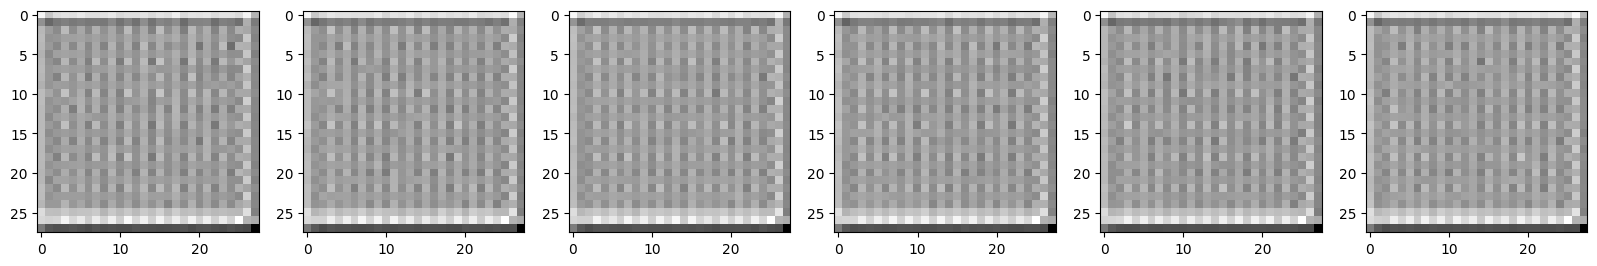

In [10]:
model_G.eval()
noise = torch.randn((BATCH_SIZE, 1, 7, 7), dtype=torch.float32).to(device)
pred = model_G(noise)

fig, axis = plt.subplots(1, 6, figsize=(20, 24))
for i, ax in enumerate(axis.flat):
    ax.imshow(pred[i].to('cpu').detach().numpy().reshape(28, 28), cmap='gray')

In [11]:
one_labels = torch.ones(BATCH_SIZE).reshape(BATCH_SIZE, 1).to(device)
zero_labels = torch.zeros(BATCH_SIZE).reshape(BATCH_SIZE, 1).to(device)

criterion = nn.BCELoss() 

optimizer_D = optim.Adam(model_D.parameters(), lr=0.00001)
optimizer_G = optim.Adam(model_G.parameters(), lr=0.00001)

G_train_ratio = 2
model_D.train()
model_G.train()
history = {"train_loss_D": [], "train_loss_G": []}
for epoch in range(N_EPOCH):
  train_loss_D = []
  train_loss_G = []
  time_s = time.perf_counter()

  for i, (data, labels) in enumerate(train_dataloader):
    
    #識別器の学習（Real）
    optimizer_D.zero_grad()
    inputs_real = data.to(device)
    outputs_real = model_D(inputs_real)
    loss_real = criterion(outputs_real, one_labels)
    loss_real.backward()
    train_loss_D.append(loss_real.item())

    #識別器の学習（Fake）
    noise = torch.randn((BATCH_SIZE, 1, 7, 7), dtype=torch.float32).to(device)
    inputs_fake = model_G(noise)
    outputs_fake = model_D(inputs_fake.detach())
    loss_fake = criterion(outputs_fake, zero_labels)
    loss_fake.backward()
    train_loss_D.append(loss_fake.item())
    optimizer_D.step()

    #生成器の学習
    for _ in range(G_train_ratio):
      optimizer_G.zero_grad()
      noise = torch.randn((BATCH_SIZE, 1, 7, 7), dtype=torch.float32).to(device)
      inputs_fake = model_G(noise)
      outputs_fake = model_D(inputs_fake)
      loss_G = criterion(outputs_fake, one_labels)
      loss_G.backward()
      optimizer_G.step()
      train_loss_G.append(loss_G.item())

    print(f"epoch:{epoch+1}({(i + 1) / (len(train_dataloader)):.2%}) | train_loss_D: {np.mean(train_loss_D):.10f} | train_loss_G: {np.mean(train_loss_G):.10f} | Elapsed: {(time.perf_counter() - time_s):.1f}s", end='\r')

  print('')
  history["train_loss_D"].extend(train_loss_D)
  history["train_loss_G"].extend(train_loss_G)
print("finish training")

epoch:1(100.00%) | train_loss_D: 0.1264473943 | train_loss_G: 3.6972077272 | Elapsed: 175.5s
epoch:2(100.00%) | train_loss_D: 0.0828160685 | train_loss_G: 4.7109731843 | Elapsed: 165.4s
epoch:3(100.00%) | train_loss_D: 0.0727398269 | train_loss_G: 5.3256869019 | Elapsed: 174.3s
epoch:4(100.00%) | train_loss_D: 0.0603097919 | train_loss_G: 5.7312534599 | Elapsed: 160.9s
epoch:5(100.00%) | train_loss_D: 0.0614088728 | train_loss_G: 6.0674912916 | Elapsed: 170.8s
epoch:6(100.00%) | train_loss_D: 0.0538232455 | train_loss_G: 6.3476224224 | Elapsed: 179.0s
epoch:7(100.00%) | train_loss_D: 0.0544134816 | train_loss_G: 6.5318412804 | Elapsed: 175.7s
epoch:8(100.00%) | train_loss_D: 0.0443689968 | train_loss_G: 6.8877725496 | Elapsed: 165.2s
epoch:9(100.00%) | train_loss_D: 0.0420842295 | train_loss_G: 7.0973732568 | Elapsed: 177.8s
epoch:10(100.00%) | train_loss_D: 0.0444853402 | train_loss_G: 7.2469789146 | Elapsed: 170.7s
epoch:11(100.00%) | train_loss_D: 0.0452657001 | train_loss_G: 7.4166

In [12]:
torch.save(model_D, '../models/GAN_model_D.pth')
torch.save(model_G, '../models/GAN_model_G.pth')

Text(0, 0.5, 'train_loss_G')

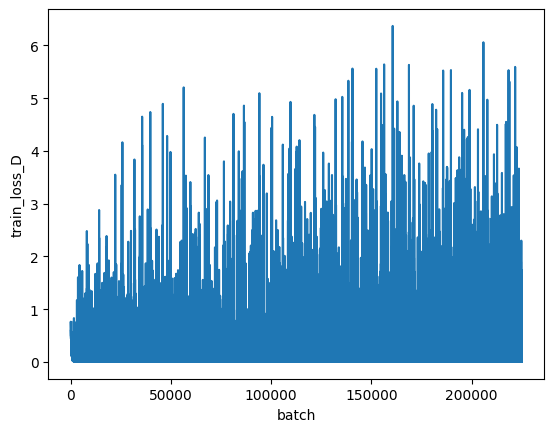

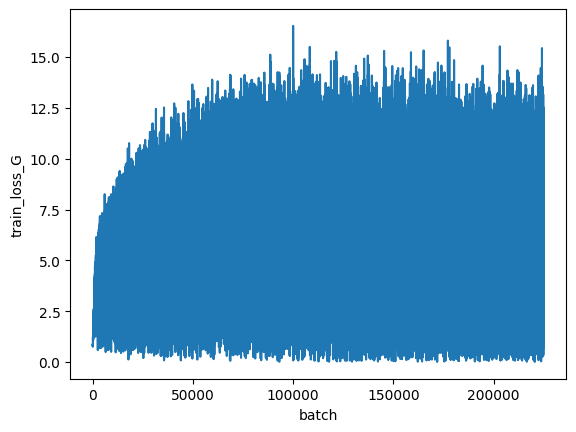

In [13]:
plt.figure()
plt.plot(history["train_loss_D"])
plt.xlabel('batch')
plt.ylabel('train_loss_D')

plt.figure()
plt.plot(history["train_loss_G"])
plt.xlabel('batch')
plt.ylabel('train_loss_G')

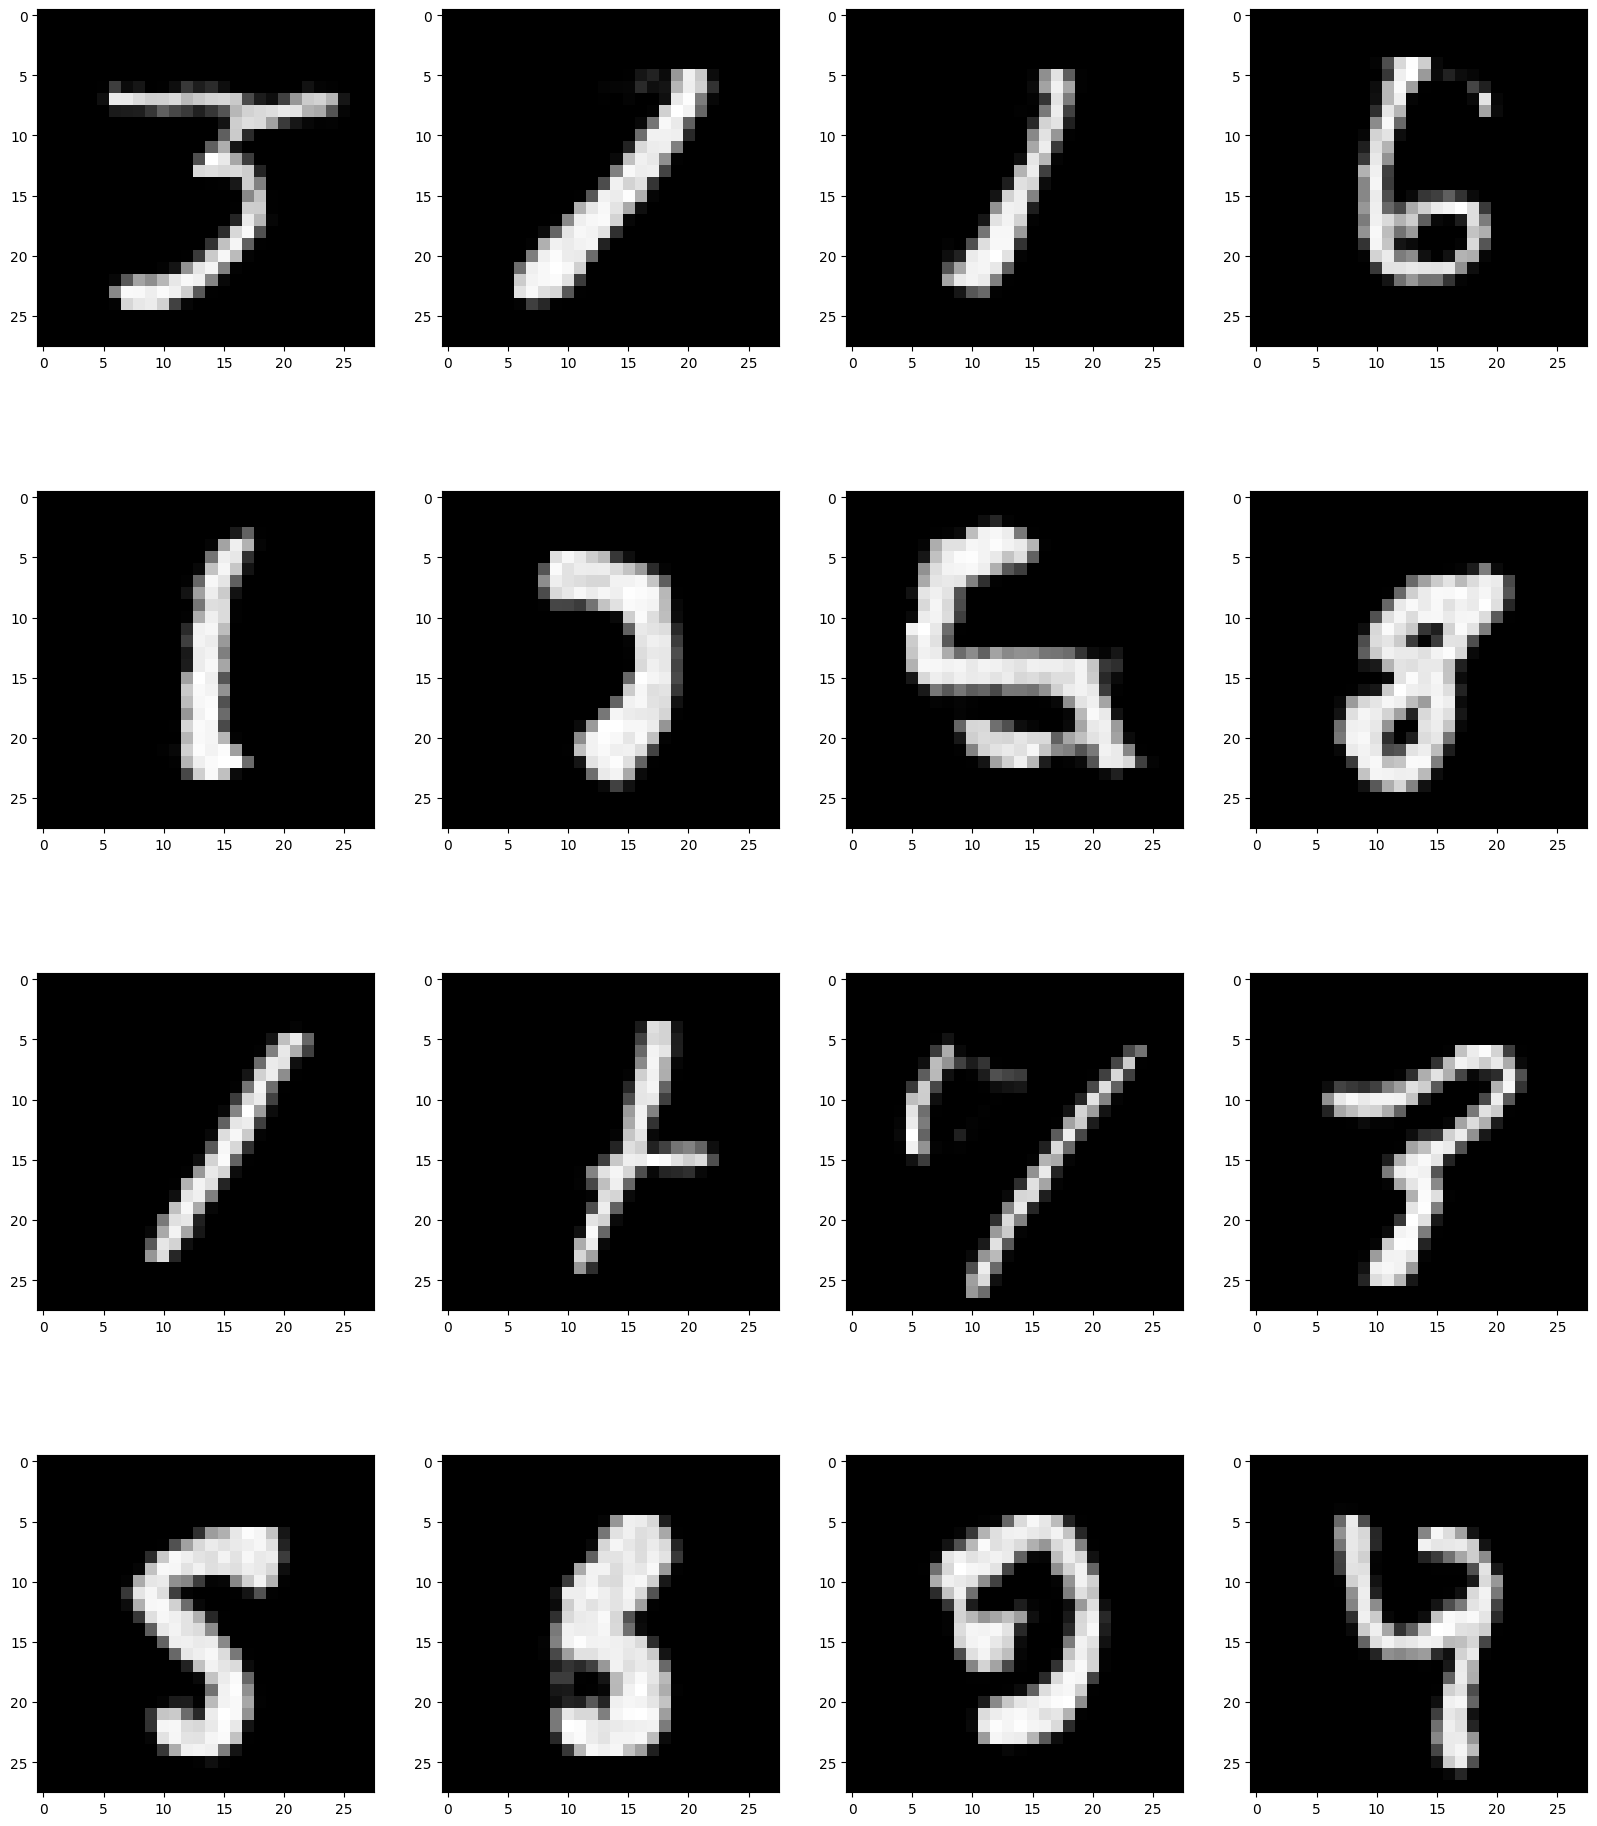

In [14]:
with torch.no_grad():
    model_G.eval()
    noise = torch.randn((BATCH_SIZE, 1, 7, 7), dtype=torch.float32).to(device)
    pred = model_G(noise)
    
fig, axis = plt.subplots(4, 4, figsize=(20, 24))
for i, ax in enumerate(axis.flat):
    ax.imshow(pred[i].to('cpu').detach().numpy().reshape((28, 28)), cmap='gray')